In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

/home/maverick/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
    'batch_size': 16,
    'num_workers': 2,
    'num_epochs': 10,
    'learning_rate': 3e-4,
    'img_size': 224,
    'num_classes': 10,
    'patch_size': 16,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}


In [3]:
train_transform = transforms.Compose([
    transforms.Resize(config['img_size']),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(config['img_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class ViTWithAttention(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.vit = models.VisionTransformer(
            image_size=224,
            patch_size=16,
            num_layers=6,
            num_heads=4,
            hidden_dim=384,
            mlp_dim=1024,
            num_classes=num_classes,
            dropout=0.1
        )
        
    def forward(self, x):
        return self.vit(x)

model = ViTWithAttention(num_classes=10).to(config['device'])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['num_epochs'])

In [ ]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(loader):
        inputs, targets = inputs.to(config['device']), targets.to(config['device'])
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    return total_loss/len(loader), 100*correct/total

def test(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(config['device']), targets.to(config['device'])
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    return total_loss/len(loader), 100*correct/total

In [ ]:
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(config['num_epochs']):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer)
    test_loss, test_acc = test(model, test_loader)
    
    scheduler.step()
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1}/{config['num_epochs']}")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Acc: {test_acc:.2f}%\n")

100%|██████████| 3125/3125 [04:13<00:00, 12.35it/s]


Epoch 1/10
Train Loss: 1.9328 | Acc: 26.44%
Test Loss: 1.7978 | Acc: 31.40%



100%|██████████| 3125/3125 [04:05<00:00, 12.75it/s]


Epoch 2/10
Train Loss: 1.7487 | Acc: 34.88%
Test Loss: 1.7222 | Acc: 34.12%



100%|██████████| 3125/3125 [04:08<00:00, 12.56it/s]


Epoch 3/10
Train Loss: 1.6081 | Acc: 40.82%
Test Loss: 1.6401 | Acc: 37.68%



100%|██████████| 3125/3125 [04:09<00:00, 12.54it/s]


Epoch 4/10
Train Loss: 1.4947 | Acc: 45.19%
Test Loss: 1.5918 | Acc: 40.53%



100%|██████████| 3125/3125 [04:14<00:00, 12.28it/s]


Epoch 5/10
Train Loss: 1.4043 | Acc: 48.73%
Test Loss: 1.5077 | Acc: 44.27%



100%|██████████| 3125/3125 [04:15<00:00, 12.24it/s]


Epoch 6/10
Train Loss: 1.3197 | Acc: 51.90%
Test Loss: 1.4023 | Acc: 49.48%



100%|██████████| 3125/3125 [04:04<00:00, 12.77it/s]


Epoch 7/10
Train Loss: 1.2449 | Acc: 54.87%
Test Loss: 1.3448 | Acc: 51.11%



100%|██████████| 3125/3125 [04:06<00:00, 12.68it/s]


Epoch 8/10
Train Loss: 1.1794 | Acc: 57.58%
Test Loss: 1.3039 | Acc: 52.85%



100%|██████████| 3125/3125 [04:11<00:00, 12.43it/s]


Epoch 9/10
Train Loss: 1.1300 | Acc: 59.19%
Test Loss: 1.2637 | Acc: 54.30%



100%|██████████| 3125/3125 [04:11<00:00, 12.42it/s]


Epoch 10/10
Train Loss: 1.0972 | Acc: 60.38%
Test Loss: 1.2425 | Acc: 55.39%



# Finetuning

In [5]:
from torch.cuda.amp import autocast, GradScaler
from timm import create_model
import torch.optim as optim


In [6]:
# CIFAR10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [7]:
def load_vit_tiny(num_classes=10, pretrained=True):
    """
    Load ViT-Tiny model with pre-trained weights
    """
    model = create_model(
        'vit_tiny_patch16_224',  # Specifically using ViT-Tiny with 16x16 patch size
        pretrained=pretrained,   # Load pre-trained weights
        num_classes=num_classes  # Set output size to CIFAR10 classes
    )
    
    # Print model information
    total_params = sum(p.numel() for p in model.parameters())
    print(f"ViT-Tiny loaded with {total_params:,} parameters")
    print(f"Model size: {total_params * 4 / (1024 * 1024):.2f} MB")
    
    return model

In [8]:
model = load_vit_tiny(num_classes=10)
model = model.to(config['device'])

ViT-Tiny loaded with 5,526,346 parameters
Model size: 21.08 MB


In [9]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)

In [10]:
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [11]:
scaler = GradScaler()

In [12]:
def train_epoch(model, dataloader, criterion, optimizer, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(config['device']), labels.to(config['device'])
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Print progress
        if (i+1) % 1500 == 0:
            print(f'Batch: {i+1}/{len(dataloader)}, Loss: {running_loss/1500:.3f}, Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0
    
    return 100. * correct / total

In [13]:
def evaluate(model, dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(config['device']), labels.to(config['device'])
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_loss = test_loss / len(dataloader)
    accuracy = 100. * correct / total
    print(f'Test Loss: {avg_loss:.3f}, Test Acc: {accuracy:.2f}%')
    
    return accuracy

In [14]:
num_epochs = 5
train_acc_history = []
test_acc_history = []

In [15]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler)
    test_acc = evaluate(model, test_loader, criterion)
    scheduler.step()
    
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    
    # Save model checkpoint
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': train_acc,
            'test_acc': test_acc
        }, f'vit_tiny_cifar10_epoch_{epoch+1}.pth')

# Save final model
torch.save(model.state_dict(), 'vit_tiny_cifar10_final.pth')
print("Final model saved successfully")



Epoch 1/5
Batch: 1500/3125, Loss: 1.895, Acc: 29.52%
Batch: 3000/3125, Loss: 1.590, Acc: 35.38%
Test Loss: 1.429, Test Acc: 47.04%

Epoch 2/5
Batch: 1500/3125, Loss: 1.422, Acc: 47.51%
Batch: 3000/3125, Loss: 1.320, Acc: 49.74%
Test Loss: 1.291, Test Acc: 53.00%

Epoch 3/5
Batch: 1500/3125, Loss: 1.216, Acc: 55.88%
Batch: 3000/3125, Loss: 1.164, Acc: 56.89%
Test Loss: 1.078, Test Acc: 61.41%

Epoch 4/5
Batch: 1500/3125, Loss: 1.098, Acc: 60.44%
Batch: 3000/3125, Loss: 1.060, Acc: 61.29%
Test Loss: 1.081, Test Acc: 60.99%

Epoch 5/5
Batch: 1500/3125, Loss: 1.007, Acc: 64.13%
Batch: 3000/3125, Loss: 0.976, Acc: 64.70%
Test Loss: 1.016, Test Acc: 63.53%
Final model saved successfully


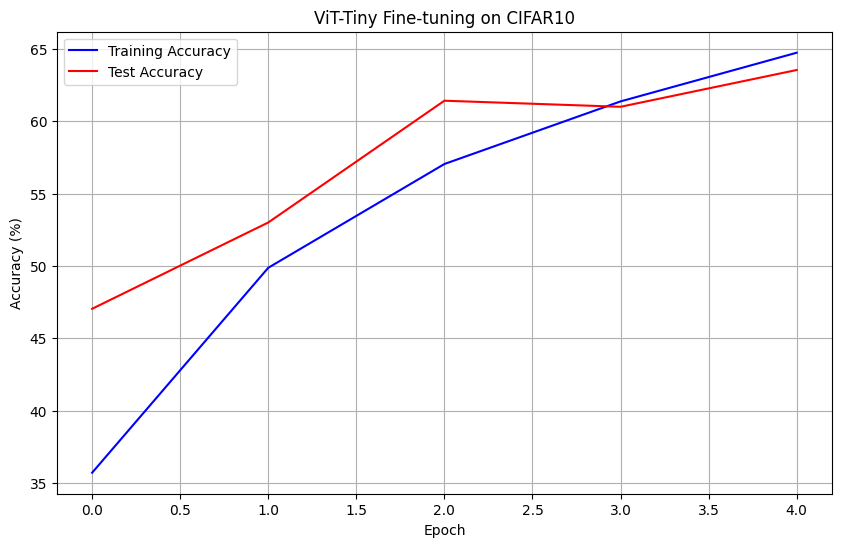

: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_acc_history, 'b-', label='Training Accuracy')
plt.plot(test_acc_history, 'r-', label='Test Accuracy')
plt.title('ViT-Tiny Fine-tuning on CIFAR10')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('vit_tiny_cifar10_accuracy.png')
plt.show()